<!--BOOK_INFORMATION-->
<a href="https://www.packtpub.com/big-data-and-business-intelligence/machine-learning-opencv" target="_blank"><img align="left" src="data/cover.jpg" style="width: 76px; height: 100px; background: white; padding: 1px; border: 1px solid black; margin-right:10px;"></a>
*This notebook contains an excerpt from the book [Machine Learning for OpenCV](https://www.packtpub.com/big-data-and-business-intelligence/machine-learning-opencv) by Michael Beyeler.
The code is released under the [MIT license](https://opensource.org/licenses/MIT),
and is available on [GitHub](https://github.com/mbeyeler/opencv-machine-learning).*

*Note that this excerpt contains only the raw code - the book is rich with additional explanations and illustrations.
If you find this content useful, please consider supporting the work by
[buying the book](https://www.packtpub.com/big-data-and-business-intelligence/machine-learning-opencv)!*

<!--NAVIGATION-->
< [Understanding Ensemble Methods](10.01-Understanding-Ensemble-Methods.ipynb) | [Contents](../README.md) | [Using Random Forests for Face Recognition](10.03-Using-Random-Forests-for-Face-Recognition.ipynb) >

# Combining Decision Trees Into a Random Forest

A popular variation of bagged decision trees are the so-called **random forests**. These are
essentially a collection of decision trees, where each tree is slightly different from the others.
In contrast to bagged decision trees, each tree in a random forest is trained on a slightly
different subset of data features.

Although a single tree of unlimited depth might do a relatively good job of predicting the
data, it is also prone to overfitting. The idea behind random forests is to build a large
number of trees, each of them trained on a random subset of data samples and features.
Because of the randomness of the procedure, each tree in the forest will overfit the data in a
slightly different way. The effect of overfitting can then be reduced by averaging the
predictions of the individual trees.

## Understanding the shortcomings of decision trees

The effect of overfitting the dataset, which a decision tree often falls victim of is best
demonstrated through a simple example.

For this, we will return to the `make_moons` function from scikit-learn's datasets module,
which we previously used in [Chapter 8](08.00-Discovering-Hidden-Structures-with-Unsupervised-Learning.ipynb), *Discovering Hidden Structures with Unsupervised
Learning* to organize data into two interleaving half circles. Here, we choose to generate 100
data samples belonging to two half circles, in combination with some Gaussian noise with
standard deviation 0.25:

In [1]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.25, random_state=100)

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

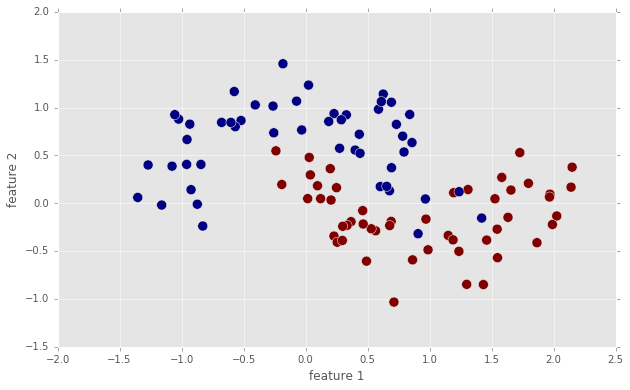

In [3]:
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], s=100, c=y)
plt.xlabel('feature 1')
plt.ylabel('feature 2');

Because of all the noise we added, the two half moons might not be apparent at first glance.
That's a perfect scenario for our current intentions, which is to show that decision trees are
tempted to overlook the general arrangement of data points (that is, the fact that they are
organized in half circles) and instead focus on the noise in the data.

To illustrate this point, we first need to split the data into training and test sets. We choose a
comfortable 75-25 split (by not specifying `train_size`), as we have done a number of times
before:

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=100
)

Now let's have some fun. What we want to do is to study how the decision boundary of a
decision tree changes as we make it deeper and deeper.

For this, we will bring back the plot_decision_boundary function from [Chapter 6](06.00-Detecting-Pedestrians-with-Support-Vector-Machines.ipynb),
*Detecting Pedestrians with Support Vector Machines* among others:

In [5]:
import numpy as np
def plot_decision_boundary(classifier, X_test, y_test):
    # create a mesh to plot in
    h = 0.02  # step size in mesh
    x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
    y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    X_hypo = np.c_[xx.ravel().astype(np.float32),
                   yy.ravel().astype(np.float32)]
    ret = classifier.predict(X_hypo)
    if isinstance(ret, tuple):
        zz = ret[1]
    else:
        zz = ret
    zz = zz.reshape(xx.shape)
    
    plt.contourf(xx, yy, zz, cmap=plt.cm.coolwarm, alpha=0.8)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=200)

Then we can code up a for loop, where at each iteration, we fit a tree of a different depth:

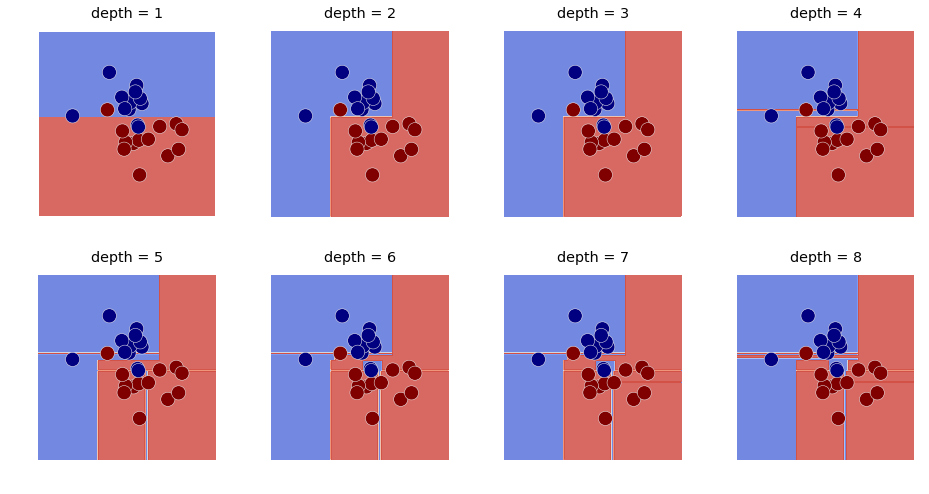

In [6]:
from sklearn.tree import DecisionTreeClassifier
plt.figure(figsize=(16, 8))
for depth in range(1, 9):
    plt.subplot(2, 4, depth)
    tree = DecisionTreeClassifier(max_depth=depth)
    tree.fit(X, y)
    plot_decision_boundary(tree, X_test, y_test)
    plt.axis('off')
    plt.title('depth = %d' % depth)

As we continue to build deeper and deeper trees, we notice something strange: the deeper
the tree, the more likely it is to get strangely shaped decision regions, such as the tall and
skinny patches in the rightmost panel of the lower row. It's clear that these patches are more
a result of the noise in the data rather than some characteristic of the underlying data
distribution. This is an indication that most of the trees are overfitting the data. After all, we
know for a fact that the data is organized into two half circles! As such, the trees with
`depth=3` or `depth=5` are probably closest to the real data distribution.

There are at least two different ways to make a decision tree less powerful:
- Train the tree only on a subset of the data
- Train the tree only on a subset of the features

Random forests do just that. In addition, they repeat the experiment many times by
building an ensemble of trees, each of which is trained on a randomly chosen subset of data
samples and/or features.

## Implementing our first random forest

In OpenCV, random forests can be built using the `RTrees_create` function from the `ml`
module:

In [7]:
import cv2
rtree = cv2.ml.RTrees_create()

The tree object provides a number of options, the most important of which are the
following:
- `setMaxDepth`: This sets the maximum possible depth of each tree in the ensemble. The actual obtained depth may be smaller if other termination criteria are met first.
- `setMinSampleCount`: This sets the minimum number of samples that a node can contain for it to get split.
- `setMaxCategories`: This sets the maximum number of categories allowed. Setting the number of categories to a smaller value than the actual number of classes in the data performs subset estimation.
- `setTermCriteria`: This sets the termination criteria of the algorithm. This is also where you set the number of trees in the forest.

We can specify the number of trees in the forest by passing an integer `n_trees` to the
`setTermCriteria` method. Here, we also want to tell the algorithm to quit once the score
does not increase by at least `eps` from one iteration to the next:

In [8]:
n_trees = 10
eps = 0.01
criteria = (cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS,
            n_trees, eps)
rtree.setTermCriteria(criteria)

Then we are ready to train the classifier on the data from the preceding code:

In [9]:
rtree.train(X_train.astype(np.float32), cv2.ml.ROW_SAMPLE, y_train);

The test labels can be predicted with the `predict` method:

In [10]:
_, y_hat = rtree.predict(X_test.astype(np.float32))

Using scikit-learn's `accuracy_score`, we can evaluate the model on the test set:

In [11]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_hat)

0.83999999999999997

After training, we can pass the predicted labels to the `plot_decision_boundary` function:

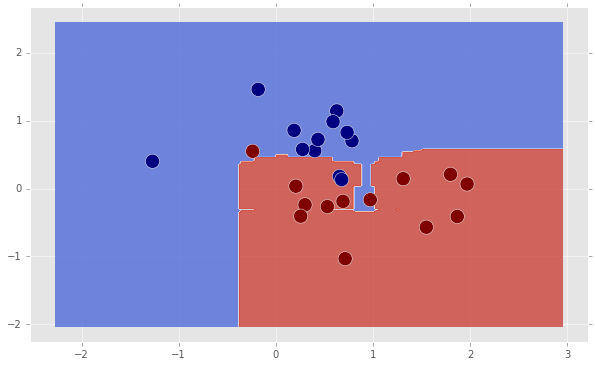

In [12]:
plt.figure(figsize=(10, 6))
plot_decision_boundary(rtree, X_test, y_test)

## Implementing a random forest with scikit-learn

Alternatively, we can implement random forests using scikit-learn:

In [13]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=10, random_state=200)

Here, we have a number of options to customize the ensemble:
- `n_estimators`: This specifies the number of trees in the forest.
- `criterion`: This specifies the node splitting criterion. Setting `criterion='gini'` implements the Gini impurity, whereas setting `criterion='entropy'` implements information gain.
- `max_features`: This specifies the number (or fraction) of features to consider at each node split.
- `max_depth`: This specifies the maximum depth of each tree.
- `min_samples`: This specifies the minimum number of samples required to split a node.

We can then fit the random forest to the data and score it like any other estimator:

In [14]:
forest.fit(X_train, y_train)
forest.score(X_test, y_test)

0.83999999999999997

This gives roughly the same result as in OpenCV. We can use our helper function to plot the
decision boundary:

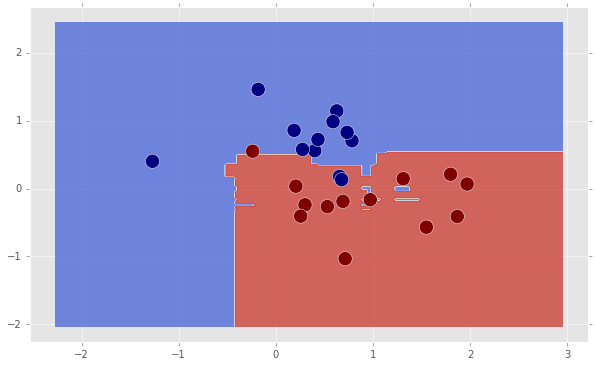

In [15]:
plt.figure(figsize=(10, 6))
plot_decision_boundary(forest, X_test, y_test)

## Implementing extremely randomized trees

Random forests are already pretty arbitrary. But what if we wanted to take the randomness
to its extreme?

In **extremely randomized trees** (see `ExtraTreesClassifier` and `ExtraTreesRegressor`
classes), the randomness is taken even further than in random forests. Remember how
decision trees usually choose a threshold for every feature so that the purity of the node
split is maximized. Extremely randomized trees, on the other hand, choose these thresholds
at random. The best one of these randomly-generated thresholds is then used as the
splitting rule.

We can build an extremely randomized tree as follows:

In [16]:
from sklearn.ensemble import ExtraTreesClassifier
extra_tree = ExtraTreesClassifier(n_estimators=10, random_state=100)

To illustrate the difference between a single decision tree, a random forest, and extremely
randomized trees, let's consider a simple dataset, such as the Iris dataset:

In [17]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data[:, [0, 2]]
y = iris.target

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=100
)

We can then fit and score the tree object the same way we did before:

In [19]:
extra_tree.fit(X_train, y_train)
extra_tree.score(X_test, y_test)

0.92105263157894735

For comparison, using a random forest would have resulted in the same performance:

In [20]:
forest = RandomForestClassifier(n_estimators=10, random_state=100)
forest.fit(X_train, y_train)
forest.score(X_test, y_test)

0.92105263157894735

In fact, the same is true for a single tree:

In [21]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
tree.score(X_test, y_test)

0.92105263157894735

So what's the difference between them?

To answer this question, we have to look at the
decision boundaries. Fortunately, we have already imported our
`plot_decision_boundary` helper function in the preceding section, so all we need to do is
pass the different classifier objects to it.

We will build a list of classifiers, where each entry in the list is a tuple that contains an
index, a name for the classifier, and the classifier object:

In [22]:
classifiers = [
    (1, 'decision tree', tree),
    (2, 'random forest', forest),
    (3, 'extremely randomized trees', extra_tree)
]

Then it's easy to pass the list of classifiers to our helper function such that the decision
landscape of every classifier is drawn in its own subplot:

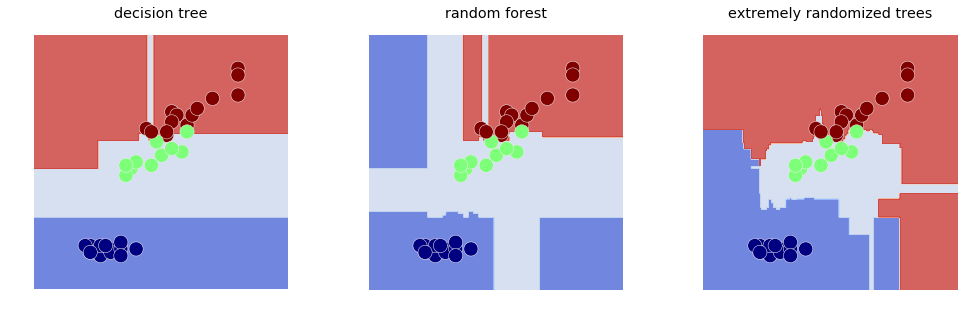

In [23]:
plt.figure(figsize=(17, 5))
for sp, name, model in classifiers:
    plt.subplot(1, 3, sp)
    plot_decision_boundary(model, X_test, y_test)
    plt.title(name)
    plt.axis('off')

Now, the differences between the three classifiers become clearer. We see the single tree
drawing by far the simplest decision boundaries, splitting the landscape using horizontal
decision boundaries. The random forest is able to more clearly separate the cloud of data
points in the lower left of the decision landscape. However, only extremely randomized
trees were able to corner the cloud of data points towards the center of the landscape from
all sides.

Now that we know about all the different variations of tree ensembles, let's move on to a
real-world dataset.

<!--NAVIGATION-->
< [Understanding Ensemble Methods](10.01-Understanding-Ensemble-Methods.ipynb) | [Contents](../README.md) | [Using Random Forests for Face Recognition](10.03-Using-Random-Forests-for-Face-Recognition.ipynb) >